In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
os.chdir('/content/gdrive/My Drive')

Mounted at /content/gdrive


In [3]:
import yfinance as yf

nvda = yf.Ticker("NVDA")
data = nvda.history(period="1y")

data.to_csv("/content/NVDA_stock_data.csv")

from google.colab import files
files.download("/content/NVDA_stock_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

#Fetch NVDA data for the last year
nvda = yf.Ticker("NVDA")
data = nvda.history(period = "1y")


In [17]:
data['Date'] = data.index
#Daily Return
data['Daily Return'] = data['Close'].pct_change() * 100

#Calculate 20 and 50 day Moving Averages
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data['Volatility'] = data['Close'].pct_change().rolling(window=20).std()

#Detect Bullish and Bearish Crossovers
data['Bullish Cross'] = (data['MA_20'] > data['MA_50']) & (data['MA_20'].shift(1) <= data['MA_50'].shift(1))
data['Bearish Cross'] = (data['MA_20'] < data['MA_50']) & (data['MA_20'].shift(1) >= data['MA_50'].shift(1))

<ipython-input-18-d3f675e50675>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlc['Date'] = ohlc['Date'].apply(mdates.date2num)


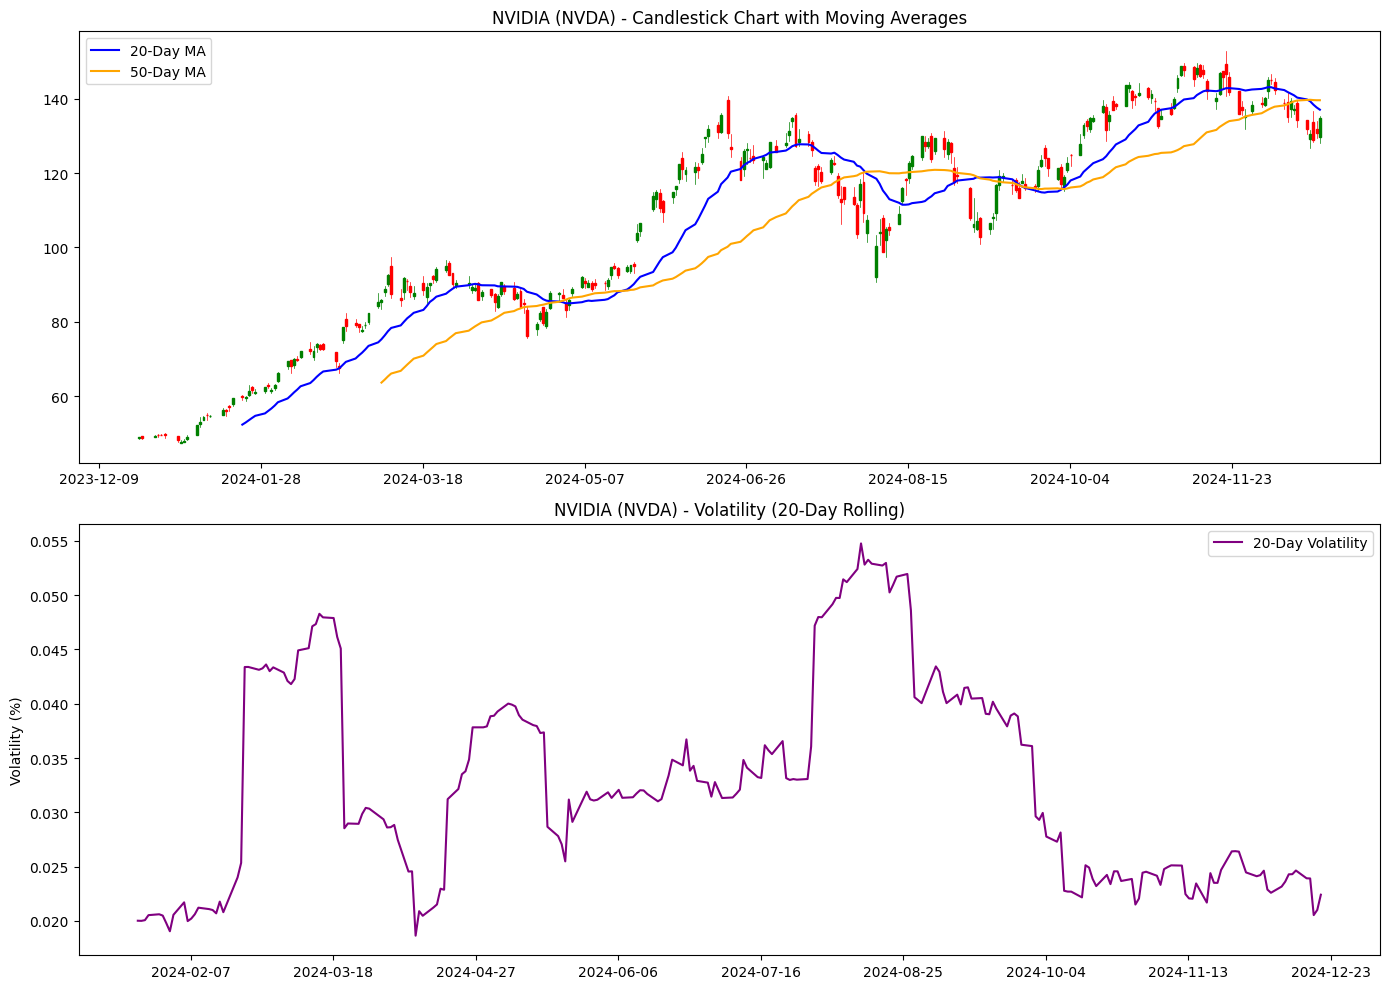

In [18]:
!pip install yfinance mplfinance
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.ticker as ticker

ohlc = data[['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = ohlc['Date'].apply(mdates.date2num)

fig, ax = plt.subplots(2, figsize=(14, 10))

ax[0].set_title("NVIDIA (NVDA) - Candlestick Chart with Moving Averages")
candlestick_ohlc(ax[0], ohlc.values, width=0.6, colorup='green', colordown='red')
ax[0].plot(data['Date'], data['MA_20'], label='20-Day MA', color='blue', linewidth=1.5)
ax[0].plot(data['Date'], data['MA_50'], label='50-Day MA', color='orange', linewidth=1.5)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(10))
ax[0].legend()

ax[1].set_title("NVIDIA (NVDA) - Volatility (20-Day Rolling)")
ax[1].plot(data['Date'], data['Volatility'], label='20-Day Volatility', color='purple')
ax[1].set_ylabel('Volatility (%)')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(10))
ax[1].legend()

plt.tight_layout()
plt.show()

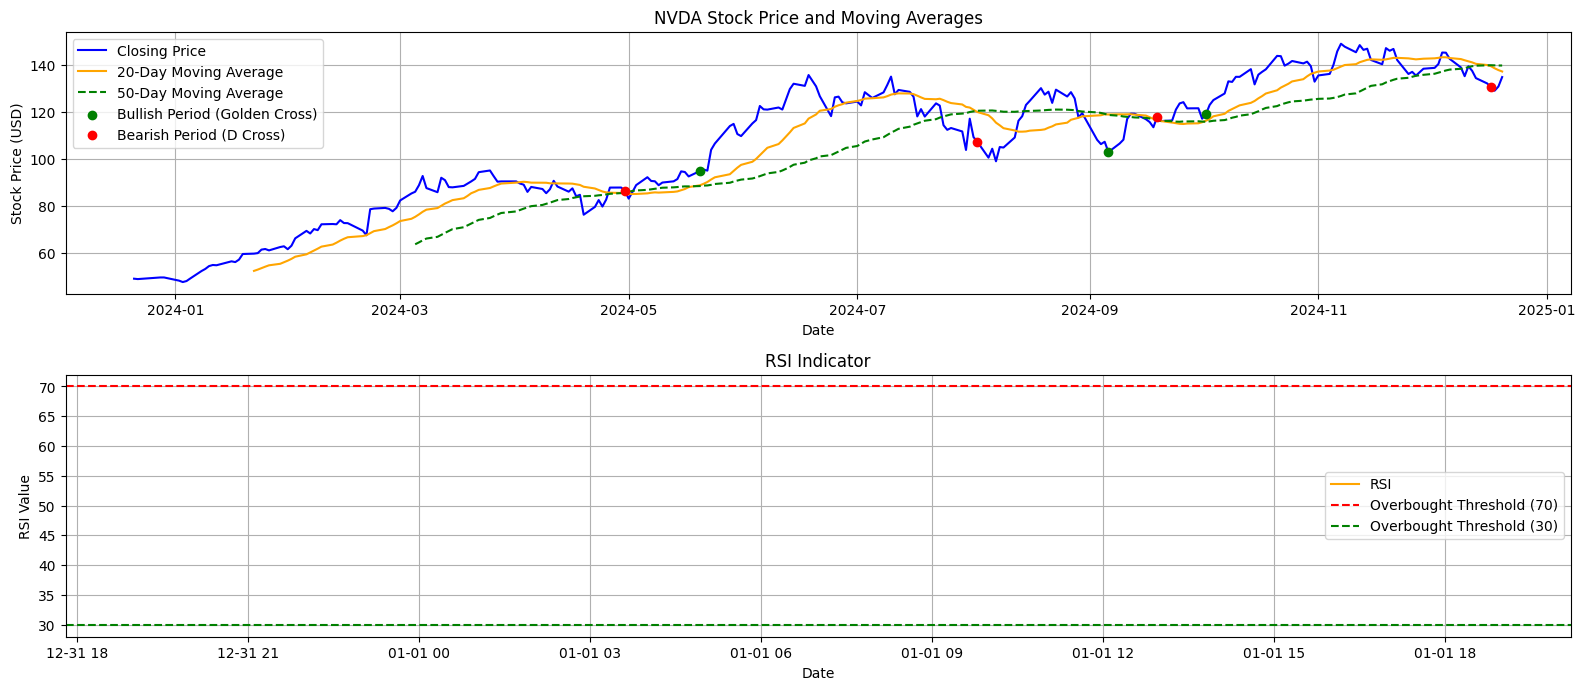

Total Bullish Days: 140
Total Bearish Days: 110
Overall Stock Performance (%): 175.03201040284543
Average Daily Volatility (%): 3.299493838368885
Total Bullish Crosses: 3
Total Bearish Crosses: 4
Overbought Periods (RSI > 70): 0
Oversold Periods (RSI < 30): 0


In [19]:
def calculate_rsi(data, period=14):
  delta = data['Close'].diff()
  gain = np.where(delta > 0, delta, 0)
  loss = np.where(delta < 0, -delta, 0)

  avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
  avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()

  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  return rsi

data['RSI'] = calculate_rsi(data)

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
plt.plot(data['Date'], data['MA_20'], label='20-Day Moving Average', color='orange')
plt.plot(data['Date'], data['MA_50'], label='50-Day Moving Average', linestyle='--', color='green')
plt.scatter(data.loc[data['Bullish Cross'], 'Date'], data.loc[data['Bullish Cross'], 'Close'], color='green', label='Bullish Period (Golden Cross)', zorder=5)
plt.scatter(data.loc[data['Bearish Cross'], 'Date'], data.loc[data['Bearish Cross'], 'Close'], color='red', label='Bearish Period (D Cross)', zorder=5)
plt.title("NVDA Stock Price and Moving Averages")
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(data['Date'], data['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought Threshold (70)')
plt.axhline(30, color='green', linestyle='--', label='Overbought Threshold (30)')
plt.title('RSI Indicator')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

bullish_days = data['Daily Return'] > 0
bearish_days = data['Daily Return'] < 0

summary = {
    'Total Bullish Days': bullish_days.sum(),
    'Total Bearish Days': bearish_days.sum(),
    'Overall Stock Performance (%)': (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0] * 100,
    'Average Daily Volatility (%)': data['Daily Return'].std(),
    'Total Bullish Crosses': data["Bullish Cross"].sum(),
    'Total Bearish Crosses': data["Bearish Cross"].sum(),
    'Overbought Periods (RSI > 70)': data[data['RSI'] > 70].shape[0],
    'Oversold Periods (RSI < 30)': data[data['RSI'] < 30].shape[0]
}

for key, value in summary.items():
  print(f"{key}: {value}")